## 1. Load line charts dataset

In [1]:
from analyze_line_charts import *

line_rows = load_line_rows() 

len(line_rows)


640

## 2. Count how many unique questions exist in the line dataset

In [2]:
count_unique_questions = count_unique_questions(line_rows)
print(f"Number of unique questions: {count_unique_questions}")


The number of questions in the line dataset is 16
Number of unique questions: ['What was the price of a barrel of oil in February 2015? Options: $57.36, $47.82, $50.24, $39.72, Omit'
 'In which month was the price of a barrel of oil the lowest in 2015? Options: March, May, July,December, Omit'
 'What was the price range of a barrel of oil in 2015? Options: $35 - $65, $48.36 - $60.95, $37.04 - $48.36, $37.04 - $60.95, Omit'
 'Over the course of the second half of 2015, the price of a barrel of oil was ____________. Options: rising, falling, staying, Omit'
 'About how much did the price of a barrel of oil fall from April to September in 2015? Options: $4, $15, $17, $45, Omit'
 'What was the average price of a pound of coffee beans in September 2013? Options: $4.9, $5.0, $5.1, $5.2, Omit'
 'When was the average price of a pound of coffee beans at minimum? Options: April 2013, September 2013, June 2014, December 2014, Omit'
 'What was the range of the average price of a pound of coffee bea

In [3]:
question_types = line_rows[["question", "question_type"]].drop_duplicates()

question_types


,question,question_type
0,What was the price of a barrel of oil in Febru...,Retrieve Value
40,In which month was the price of a barrel of oi...,Find Extremum
80,What was the price range of a barrel of oil in...,Determine Range
120,"Over the course of the second half of 2015, th...",Find Correlations/Trends
160,About how much did the price of a barrel of oi...,Make Comparisons
200,What was the average price of a pound of coffe...,Retrieve Value
240,When was the average price of a pound of coffe...,Find Extremum
280,What was the range of the average price of a p...,Determine Range
320,"Over the course of 2013, the average price of ...",Find Correlations/Trends
360,For how many months was the average price of a...,Make Comparisons


In [4]:
# Count the number of unique questions per question type
question_type_counts = line_rows[['question', 'question_type']].drop_duplicates().groupby('question_type').size().reset_index(name='question_count')

print(question_type_counts)


              question_type  question_count
0           Determine Range               3
1  Find Correlations/Trends               2
2             Find Extremum               3
3          Make Comparisons               4
4            Retrieve Value               4


In [5]:
# Group questions by their question type and format as a numbered list
grouped = line_rows[['question', 'question_type']].drop_duplicates().groupby('question_type')

for qtype, group in grouped:
    print(f"\n{qtype}:\n")
    for i, question in enumerate(group['question'].tolist(), 1): 
        print(f"{i}. {question}")


Determine Range:

1. What was the price range of a barrel of oil in 2015? Options: $35 - $65, $48.36 - $60.95, $37.04 - $48.36, $37.04 - $60.95, Omit
2. What was the range of the average price of a pound of coffee beans between January 2013 and December 2014? Options: $4.4 - $6.2, $4.6 - $5.9, $4.6 - $6.0, $4.6 - $6.1, Omit
3. Over the course of years between 2009 and 2014, what was the range of the number of girls named ‘Olivia’? Options: 1200-4700, 1200-8700, 1800-4000, 3000-8700The number of girls named ‘Isla’ was __________ from 2009 to 2012. Options: rising, falling, staying, Omit

Find Correlations/Trends:

1. Over the course of the second half of 2015, the price of a barrel of oil was ____________. Options: rising, falling, staying, Omit
2. Over the course of 2013, the average price of a pound of coffee beans was ____________. Options: rising, falling, staying, Omit

Find Extremum:

1. In which month was the price of a barrel of oil the lowest in 2015? Options: March, May, July

## 3: Generate line chart outputs

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil

# === Setup paths ===
base_path = "/hpcstor6/scratch01/h/huuthanhvy.nguyen001/Visualization_Literacy/all_dataset/generated_plots"
base_save_dir = "grouped_by_type"

# === Reset output folder ===
if os.path.exists(base_save_dir):
    shutil.rmtree(base_save_dir)
os.makedirs(base_save_dir, exist_ok=True)

# === Extract color columns ===
color_cols = [col for col in line_rows.columns if col.startswith("color_")]

# === Get unique questions and their types ===
questions_df = line_rows[['question', 'question_type']].drop_duplicates()

# === Group questions by their type ===
grouped = questions_df.groupby('question_type')

# === Loop through each question type ===
for qtype, group in grouped:
    print(f"Processing group: {qtype}")

    # Create subfolder for each question type
    qtype_folder = os.path.join(base_save_dir, qtype.replace(" ", "_"))
    os.makedirs(qtype_folder, exist_ok=True)

    # Log list for saving question/image/color info
    color_log = []

    for idx, row in group.iterrows():
        question = row['question']

        # Filter 40 rows for the current question
        q_rows = line_rows[line_rows['question'] == question].copy()
        q_rows['color_combo'] = q_rows[color_cols].apply(lambda r: tuple(r), axis=1)
        unique_color_rows = q_rows.drop_duplicates(subset='color_combo')

        for i, (_, img_row) in enumerate(unique_color_rows.iterrows()):
            img_filename = os.path.basename(img_row['filename'])
            img_path = os.path.join(base_path, img_filename)

            # Extract color name from filename
            color_name = img_filename.split("_")[-1].replace(".png", "").capitalize()

            try:
                img = Image.open(img_path)

                # Create a new figure for each image (no background, no title)
                fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
                ax.imshow(img)
                ax.axis('off')

                # Save image with color name at end
                single_filename = f"Q{idx+1}_img{i+1}_{color_name}.png"
                save_path = os.path.join(qtype_folder, single_filename)
                plt.savefig(save_path, bbox_inches='tight', dpi=150, transparent=True)
                plt.close()

                # Add log
                color_log.append({
                    'question': question,
                    'saved_filename': single_filename,
                    'color': color_name
                })

            except FileNotFoundError:
                print(f"❌ Image not found: {img_path}")

    # Save color log to CSV
    log_df = pd.DataFrame(color_log)
    log_csv_path = os.path.join(qtype_folder, 'color_log.csv')
    log_df.to_csv(log_csv_path, index=False)

print("✅ All individual plots saved with color names at the end and logs recorded.")


Processing group: Determine Range
❌ Image not found: /hpcstor6/scratch01/h/huuthanhvy.nguyen001/Visualization_Literacy/all_dataset/generated_plots/stacked_area_data.csv_line_Amelia_Leads_Girls_Names_for_Almost_a_Decade_red.png
❌ Image not found: /hpcstor6/scratch01/h/huuthanhvy.nguyen001/Visualization_Literacy/all_dataset/generated_plots/stacked_area_data.csv_line_Amelia_Leads_Girls_Names_for_Almost_a_Decade_saddlebrown.png
❌ Image not found: /hpcstor6/scratch01/h/huuthanhvy.nguyen001/Visualization_Literacy/all_dataset/generated_plots/stacked_area_data.csv_line_Amelia_Leads_Girls_Names_for_Almost_a_Decade_lightgray.png
❌ Image not found: /hpcstor6/scratch01/h/huuthanhvy.nguyen001/Visualization_Literacy/all_dataset/generated_plots/stacked_area_data.csv_line_Amelia_Leads_Girls_Names_for_Almost_a_Decade_lightpink.png
❌ Image not found: /hpcstor6/scratch01/h/huuthanhvy.nguyen001/Visualization_Literacy/all_dataset/generated_plots/stacked_area_data.csv_line_Amelia_Leads_Girls_Names_for_Almos

# 4: Visualize charts by question types

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ramihuunguyen/Documents/PhD/Visualization_Literacy/grouped_by_type/Determine_Range/Q81_img1.png'

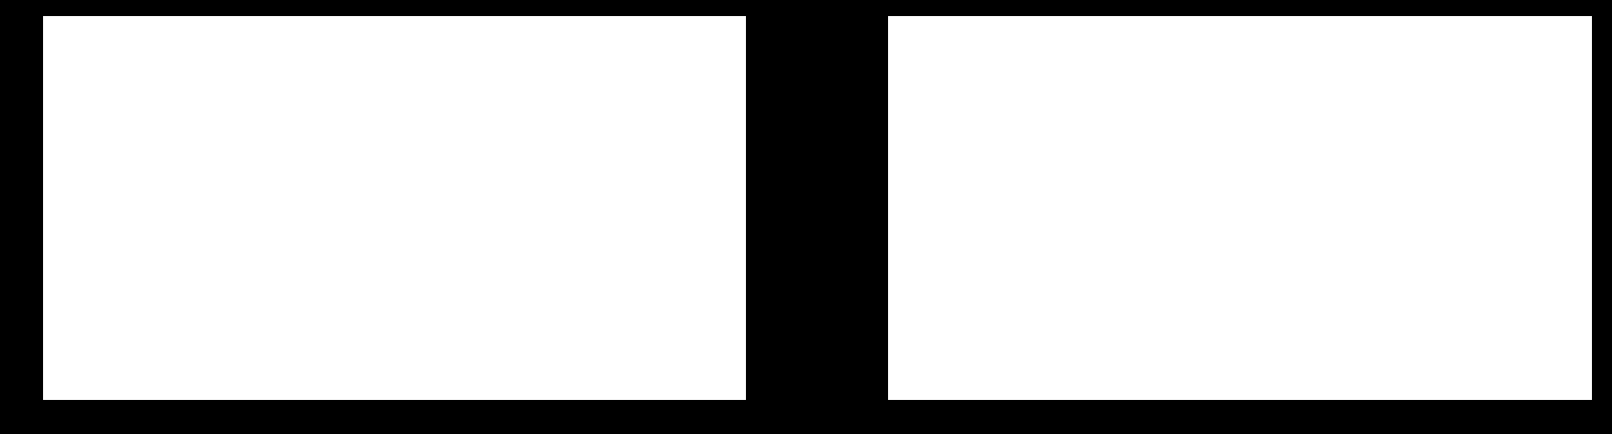

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# Define image paths and corresponding titles
image_info = [
    ("Determine Range", "/Users/ramihuunguyen/Documents/PhD/Visualization_Literacy/grouped_by_type/Determine_Range/Q81_img1.png"),
    ("Find Correlations", "/Users/ramihuunguyen/Documents/PhD/Visualization_Literacy/grouped_by_type/Find_Correlations/Trends/Q121_img1.png"),
    ("Find Extremum", "/Users/ramihuunguyen/Documents/PhD/Visualization_Literacy/grouped_by_type/Find_Extremum/Q41_img1.png"),
    ("Make Comparisons", "/Users/ramihuunguyen/Documents/PhD/Visualization_Literacy/grouped_by_type/Make_Comparisons/Q161_img1.png"),
    ("Retrieve Value", "/Users/ramihuunguyen/Documents/PhD/Visualization_Literacy/grouped_by_type/Retrieve_Value/Q1_img1.png")
]

# Create a figure with 5 subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.patch.set_facecolor('black')

# Loop through and display each image with title
for ax, (title, path) in zip(axs, image_info):
    img = Image.open(path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, fontsize=12)

plt.tight_layout(dpi=600)
plt.show()
